# Malaria Parasite Detection Using PyTorch
## Classify whether a cell is parasitized or uninfected. 
### Details:
- Author: Sanjith Hebbar<br>
- Project Type: Personal<br>
- Date: 04-12-2019<br>

### Import Libraries

In [1]:
import torch
import torchvision
import glob
import os
import os.path as osp
import numpy as np
from PIL import Image

### Custom Dataset Loading Function

In [2]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils import data
import torchvision.transforms as transforms

def custom_collate(batch):
    data = torch.stack([item[0] for item in batch])
    target = [item[1] for item in batch]
    target = torch.LongTensor(target)
    
    return [data, target]

def load_dataset(data_path, split_size):
    transform = transforms.Compose([transforms.Resize((128,128)), transforms.ToTensor()])

    train_dataset = torchvision.datasets.ImageFolder(
        root = data_path,
        transform = transform)
    
    val_dataset = torchvision.datasets.ImageFolder(
        root = data_path,
        transform = transform)
    
    test_dataset = torchvision.datasets.ImageFolder(
        root = data_path,
        transform = transform)
    
    num_train_samples = len(train_dataset)
    indices = list(range(num_train_samples))
    split = int(np.floor(split_size[1] * num_train_samples))
    np.random.shuffle(indices)
    train_idx, test_idx = indices[split:], indices[:split]
    
    num_train_samples = len(train_idx)
    indices = list(range(num_train_samples))
    split = int(np.floor(split_size[1] * num_train_samples))
    np.random.shuffle(indices)
    train_idx, val_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    val_sampler = SubsetRandomSampler(val_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        sampler = train_sampler,
        batch_size = 64,
        num_workers = 0)
    
    val_loader = torch.utils.data.DataLoader(
        val_dataset,
        sampler = val_sampler,
        batch_size = 64,
        num_workers = 0)
    
    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        sampler = test_sampler,
        batch_size = 64,
        num_workers = 0)
    
    return train_loader, val_loader, test_loader
    
    

### Split Images into train, val and test

In [3]:
data_path = 'cell_images/'
split_size = (.80, .10, .10)
train_loader, val_loader, test_loader = load_dataset(data_path, split_size)

### Check if GPU is available

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device Name: ", torch.cuda.get_device_name(device))

Device Name:  GeForce RTX 2060


### Visualise Samples from the dataset

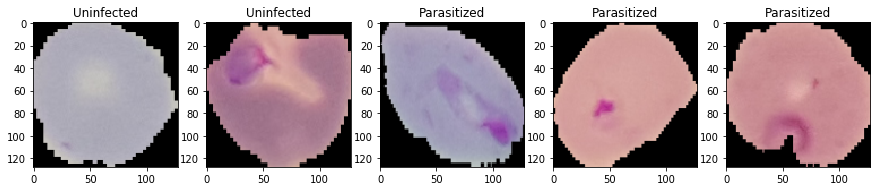

In [5]:
inputs, classes = next(iter(train_loader))
class_list = ["Parasitized", "Uninfected"]

# Define Figure
f, (ax1) = plt.subplots(1, 5)
f.set_size_inches(15, 15)

# Plot 5 samples
for i in range(0, 5):
    img = inputs[i]
    npimg = img.numpy()
    label = class_list[classes[i].item()]
    ax1[i].imshow(np.transpose(npimg, (1, 2, 0)))
    ax1[i].set_title(label)

In [11]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable

from tqdm import tqdm

class MalariaCNN(nn.Module):
    torch.manual_seed(7)
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 5)
        self.conv2 = nn.Conv2d(32, 64, 5)
        self.conv3 = nn.Conv2d(64, 128, 5)
        self.fc1 = nn.Linear(128*12*12, 64)
        self.fc2 = nn.Linear(64, 2)
        
        self.train_losses = []
        self.train_accuracies = []
        self.val_losses = []
        self.val_accuracies = []
    
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, (2,2))
        x = F.relu(self.conv3(x))
        x = F.max_pool2d(x, (2,2))
        x = x.view(-1, 128*12*12)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        x = F.log_softmax(x, dim = 1)
        return x
    
    def train(self, train_set, val_set, n_epochs, learning_rate):
        
        # Define Loss Function
        loss_function = nn.NLLLoss()
        
        # Define Optimiser
        optimizer = optim.Adam(self.parameters(), lr = learning_rate)
        
        for epoch in tqdm(range(1, n_epochs+1)):
            current_train_loss = 0.0
            current_train_acc = 0.0
            for (images, labels) in train_set:
                optimizer.zero_grad()
                images, labels = images.cuda(), labels.cuda()
                images, labels = Variable(images), Variable(labels)
                outputs = self.forward(images)
                loss = loss_function(outputs, labels)
                loss.backward()
                optimizer.step()
                current_train_loss += loss.item()
                
            # Clear memory
            del images
            del labels
            torch.cuda.empty_cache()
            
            current_val_loss = 0.0
            current_val_acc = 0.0
            correct_pred = 0
            total_pred = 0
            
            # Calculate Validation Accuracy on the entire dataset after every epoch
            for (images, labels) in val_set:
                images, labels = images.cuda(), labels.cuda()
                outputs = self.forward(Variable(images))
                current_val_loss += loss_function(outputs, labels).item()
                dummy, pred_labels = torch.max(outputs.data, 1)
                correct_pred += (pred_labels == labels).sum().item()
                total_pred += pred_labels.size(0)
            current_val_acc += (100 * correct_pred)/total_pred
            self.val_losses.append(current_val_loss/len(val_set))
            self.val_accuracies.append(current_val_acc)
            
            # Clear memory
            del images
            del labels
            torch.cuda.empty_cache()
            
            print("\nEpoch: ", epoch)
            print("Train loss: ", current_train_loss/len(train_set))
            print("Val Accuracy : ", current_val_acc)
            print("Val Loss : ", current_val_loss/len(val_set))

In [13]:
# Initiliase CNN
malaria_cnn = MalariaCNN().cuda()

# Hyperparameters
learning_rate = 0.0001

# Number of Epochs to train
n_epochs = 10

# Train Model
malaria_cnn.train(train_loader, val_loader, n_epochs, learning_rate)


 10%|████████▎                                                                          | 1/10 [00:50<07:36, 50.70s/it]


Epoch:  1
Train loss:  0.5847057247571754
Val Accuracy :  75.60483870967742
Val Loss :  0.4948621812539223



 20%|████████████████▌                                                                  | 2/10 [01:40<06:43, 50.42s/it]


Epoch:  2
Train loss:  0.34223819829331426
Val Accuracy :  91.73387096774194
Val Loss :  0.22050854659233338



 30%|████████████████████████▉                                                          | 3/10 [02:30<05:51, 50.24s/it]


Epoch:  3
Train loss:  0.18552931910514148
Val Accuracy :  94.11290322580645
Val Loss :  0.17762955736655456



 40%|█████████████████████████████████▏                                                 | 4/10 [03:21<05:02, 50.38s/it]


Epoch:  4
Train loss:  0.16014692553967494
Val Accuracy :  94.83870967741936
Val Loss :  0.16550887070405176



 50%|█████████████████████████████████████████▌                                         | 5/10 [04:11<04:11, 50.35s/it]


Epoch:  5
Train loss:  0.14720372392403705
Val Accuracy :  94.0725806451613
Val Loss :  0.16821490572049067



 60%|█████████████████████████████████████████████████▊                                 | 6/10 [05:02<03:22, 50.52s/it]


Epoch:  6
Train loss:  0.1388315663841102
Val Accuracy :  94.59677419354838
Val Loss :  0.15820906741114762



 70%|██████████████████████████████████████████████████████████                         | 7/10 [05:53<02:32, 50.81s/it]


Epoch:  7
Train loss:  0.13234404223653512
Val Accuracy :  95.20161290322581
Val Loss :  0.14868095154181504



 80%|██████████████████████████████████████████████████████████████████▍                | 8/10 [06:45<01:42, 51.18s/it]


Epoch:  8
Train loss:  0.12592064421677315
Val Accuracy :  95.12096774193549
Val Loss :  0.14803028087585401



 90%|██████████████████████████████████████████████████████████████████████████▋        | 9/10 [07:38<00:51, 51.70s/it]


Epoch:  9
Train loss:  0.12201454760480064
Val Accuracy :  94.71774193548387
Val Loss :  0.14687627014250326



100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [08:31<00:00, 51.20s/it]


Epoch:  10
Train loss:  0.11971626688531442
Val Accuracy :  95.08064516129032
Val Loss :  0.14211337411632904


### Plot Loss & Accuracy Graphs for Validation Set

In [ ]:
import matplotlib.pyplot as plt

# Define Figure
f, (ax1) = plt.subplots(1, 2)
f.set_size_inches(15,5)

# Loss
ax1[0].plot(malaria_cnn.val_losses)
ax1[0].set_title("Validation Loss")
ax1[0].set_xlabel("Epochs")
ax1[0].set_xlim([0,9])

# Accuracies
ax1[1].plot(malaria_cnn.val_accuracies)
ax1[1].set_xlim([0,9])
ax1[1].set_title("Validation Accuracy")
ax1[1].set_xlabel("Epochs")

### Evaluate on Test Set

In [71]:
# Calculate Test Accuracy on the entire set after every epoch
best_model = malaria_cnn.cpu()
correct_pred = 0
total_pred = 0
current_test_acc = 0
for (images, labels) in test_loader:
    outputs = best_model.forward(Variable(images))
    dummy, pred_labels = torch.max(outputs.data, 1)
    correct_pred += (pred_labels == labels).sum().item()
    total_pred += pred_labels.size(0)
current_test_acc += (100 * correct_pred)/total_pred
print("Test Accuracy: ", current_test_acc)

Test Accuracy:  95.86206896551724


In [75]:
def predict_image(image):
    image = Variable(image, requires_grad=True)
    image = image.unsqueeze(0)
    return image

### Visualise on Test Set

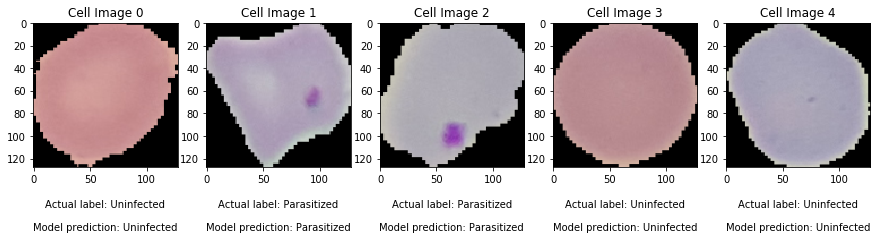

In [95]:
inputs, classes = next(iter(test_loader))
class_list = ["Parasitized", "Uninfected"]
predict_transform = transforms.Compose([transforms.Resize(128, 128), transforms.ToTensor()])
    
# Define Figure
f, (ax1) = plt.subplots(1, 5)
f.set_size_inches(15, 15)

# Plot 5 samples
for i in range(0, 5):
    img = inputs[i]
    output = best_model.forward(predict_image(img))
    dummy, pred_label = torch.max(output.data, 1)
    npimg = img.numpy()
    ax1[i].imshow(np.transpose(npimg, (1, 2, 0)))
    ax1[i].set_title("Cell Image "+ str(i))
    ground_truth = class_list[classes[i].item()]
    ax1[i].set_xlabel("\nActual label: "+ ground_truth+"\n\nModel prediction: "+class_list[pred_label])